In [1]:
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import time
import glob
from lxml.html import parse
from sphfile import SPHFile
import pydub
import audiosegment
import pandas as pd
from collections import Counter
from bs4 import BeautifulSoup
import sys
import os
from tqdm.notebook import tqdm
from itertools import permutations
import torch
import torch.nn.functional as F
from librosa.core import resample
EPS = 1e-8
import pathlib
def create_dir(filename):
    pathlib.Path('/'.join(filename.split('/')[:-1])).mkdir(parents=True, exist_ok=True)
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)
old_sr = 16000
new_sr = 8000
dropout = 0.3
half = False
root = '../'
from modules import *

In [2]:
device = 0
device_ids = [0, 1, 2, 3]
torch.cuda.set_device(device)

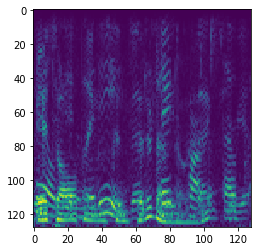

In [3]:
def load(filename):
    samples = np.load(filename)/(2**15)
    samples = resample(samples, old_sr, new_sr)
    # pad the samples
    if len(samples)>2*new_sr:
        samples = samples[:2*new_sr]
    if len(samples)<2*new_sr:
        padding = np.zeros(2*new_sr-len(samples))
        samples = np.concatenate([samples, padding])
    return samples


def make_spectrogram(segment):
    segment = segment[50:-50] # make size 200
    S = np.abs(librosa.stft(segment, n_fft = 255, hop_length = 125)) # 32 ms window, 16 ms hop
    return S

# def compute_mean_std(csv):
#     csv = pd.read_csv(csv)
#     mean = np.zeros((128, 1))
#     var = np.zeros((128, 1))
#     frames = 0
#     for i in range(200):
#         row = csv.iloc[i]
#         sig1, sig2 = load(root+row['first_file']), load(root+row['second_file'])
#         spec_dB = np.log(1+make_spectrogram(sig1+sig2))
#         mean+=np.sum(spec_dB, axis = 1, keepdims=True)
#         var+=np.sum(spec_dB**2, axis = 1, keepdims=True)
#         frames+=spec_dB.shape[1]
#     mean = mean / frames
#     std = np.sqrt(var / frames - mean**2)
#     return mean, std


class OverlayDataSet(torch.utils.data.Dataset):
    def __init__(self, csv):
        super().__init__()
        self.segments = pd.read_csv(root+csv)
        self.speakers = list(set(self.segments['speaker']))
        self.speakers.sort()
        self.spkr2idx = {spkr:i for i, spkr in enumerate(self.speakers)}

    def __len__(self):
        return len(self.segments)
    def __getitem__(self, idx):
        seg1 = self.segments.iloc[idx]
        seg2 = self.segments.iloc[np.random.randint(len(self.segments))]
        while(seg1['speaker']==seg2['speaker']):
            seg2 = self.segments.iloc[np.random.randint(len(self.segments))]
        seg3 = self.segments.iloc[np.random.randint(len(self.segments))]
        while(seg3['speaker']==seg1['speaker'] or seg3['speaker']==seg2['speaker']):
            seg3 = self.segments.iloc[np.random.randint(len(self.segments))]
        
        sig1 = np.load(root+seg1['segfile'])
        sig2 = np.load(root+seg2['segfile'])
        sig3 = np.load(root+seg3['segfile'])
        
        spec1 = np.log(1+make_spectrogram(sig1))[None, ...]
        spec2 = np.log(1+make_spectrogram(sig2))[None, ...]
        spec3 = np.log(1+make_spectrogram(sig3))[None, ...]
        
        source = np.log(1+make_spectrogram(sig1+sig2+sig3))[None, ...]
        

        return source, np.concatenate((spec1, spec2, spec3), axis = 0)



trainset = OverlayDataSet('train-segments.csv')
valset = OverlayDataSet('val-segments.csv')
testset = OverlayDataSet('test-segments.csv')
mixture, sources = trainset[5]
plt.imshow(mixture[0][::-1])

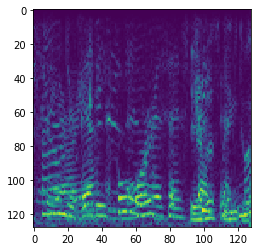

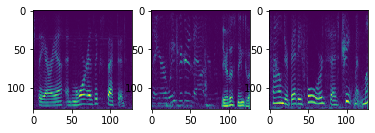

In [4]:
source, targets = trainset[3]
plt.imshow(source[0][::-1])
plt.figure()
plt.subplot(131)
plt.imshow(targets[0][::-1])
plt.subplot(132)
plt.imshow(targets[1][::-1])
plt.subplot(133)
plt.imshow(targets[2][::-1])

## Maybe try drastically increasing channel number in residual attention stage to see if it overfits

In [12]:
load_model = True
model_to_load = 'models/extractor.pth'
extractor = nn.Sequential(ResidualBlock(1, 128),
                          AttentionModule_stage1(128, 96),
                          ResDilationBlock(96, 96), # largest dilation is 32
                          ResDilationBlock(96, 96), # largest dilation is 32
                          ResDilationBlock(96, 128), # largest dilation is 32
                          AttentionModule_stage1(128, 3),
                          nn.ReLU()
                         ).cuda(device)

optimizer = torch.optim.Adam(extractor.parameters(), 0.001)

if load_model and os.path.exists(model_to_load):
    print('load model')
    checkpoint = torch.load(model_to_load)
    extractor.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    #loss = checkpoint['loss']
    bestloss = checkpoint['bestloss']
else:
    print('initializing new model')
    bestloss = 999
print('bestloss', bestloss)

extractor = torch.nn.DataParallel(extractor, device_ids = device_ids)

initializing new model
bestloss 999


In [13]:
def cal_loss(source, estimate_source):
    """
    Args:
        source: [B, C, T, F], B is batch size, F is frequency
        estimate_source: [B, C, T, F]
        source_lengths: [B, F]
    """
    min_mse, perms, min_mse_idx = cal_mse(source,estimate_source)
    loss = torch.mean(min_mse)
    reorder_estimate_source = reorder_source(estimate_source, perms, min_mse_idx)
    return loss, min_mse, estimate_source, reorder_estimate_source


def cal_mse(source, estimate_source):
    """Calculate SI-SNR with PIT training.
    Args:
        source: [B, C, T, F], B is batch size
        estimate_source: [B, C, T, F]
        source_lengths: [B], each item is between [0, T]
    """
    assert source.size() == estimate_source.size()
    B, C, T, F = source.size()


    # Step 2. SI-SNR with PIT
    # reshape to use broadcast
    s_target = torch.unsqueeze(source, dim=1)  # [B, 1, C, T, F]
    s_estimate = torch.unsqueeze(estimate_source, dim=2)  # [B, C, 1, T, F]
    # s_target = <s', s>s / ||s||^2
    pair_wise_mse = torch.sum((s_estimate - s_target)**2, dim=(3, 4))/T/F  # [B, C, C]

    ############## since distribution is asymmetric, use l2 not l1 loss ###########
    
    # Get max_snr of each utterance
    # permutations, [C!, C]
    perms = source.new_tensor(list(permutations(range(C))), dtype=torch.long)
    # one-hot, [C!, C, C]
    index = torch.unsqueeze(perms, 2)
    perms_one_hot = source.new_zeros((*perms.size(), C)).scatter_(2, index, 1)
    # [B, C!] <- [B, C, C] einsum [C!, C, C], SI-SNR sum of each permutation
    mse_set = torch.einsum('bij,pij->bp', [pair_wise_mse, perms_one_hot])
    min_mse_idx = torch.argmin(mse_set, dim=1)  # [B]
    # max_snr = torch.gather(snr_set, 1, max_snr_idx.view(-1, 1))  # [B, 1]
    min_mse, _ = torch.min(mse_set, dim=1, keepdim=True)
    min_mse /= C
    return min_mse, perms, min_mse_idx


def reorder_source(source, perms, max_snr_idx):
    """
    Args:
        source: [B, C, T]
        perms: [C!, C], permutations
        max_snr_idx: [B], each item is between [0, C!)
    Returns:
        reorder_source: [B, C, T]
    """
    B, C, *_ = source.size()
    # [B, C], permutation whose SI-SNR is max of each utterance
    # for each utterance, reorder estimate source according this permutation
    max_snr_perm = torch.index_select(perms, dim=0, index=max_snr_idx)
    # print('max_snr_perm', max_snr_perm)
    # maybe use torch.gather()/index_select()/scatter() to impl this?
    reorder_source = torch.zeros_like(source)
    for b in range(B):
        for c in range(C):
            reorder_source[b, c] = source[b, max_snr_perm[b][c]]
    return reorder_source





## If it turns out magnitude instability causes a problem, try adding a residual connection of envelope near output layer

In [14]:
batch_size = 32
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory = True, num_workers = 16)
valloader = torch.utils.data.DataLoader(valset, batch_size=16, shuffle=True, pin_memory = True, num_workers = 16)
criterion = torch.nn.BCELoss()

for epoch in range(64):
    running_loss = 0.0
    extractor.train()
    for batch_idx, (mixture, targets) in enumerate(tqdm(trainloader)):
        optimizer.zero_grad()
        mixture, targets = mixture.float().cuda(device), targets.float().cuda(device)
        outs = extractor(mixture)
        loss, min_mse, estimate_targets, reorder_estimate_targets = cal_loss(targets, outs)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(extractor.parameters(), 0.5)
        optimizer.step()

        running_loss += loss.item()
        if batch_idx % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.4f ' % 
                  (epoch + 1, batch_idx + 1, running_loss / 200))
            running_loss = 0.0
            torch.save({
            'model_state_dict': extractor.module.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'bestloss': bestloss
            }, 'models/extractor.pth')
            
    
    extractor.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch_idx, (mixture, targets) in enumerate(tqdm(valloader)):
            num_samples = mixture.shape[0]
            mixture, targets = mixture.float().cuda(device), targets.float().cuda(device)
            outs = extractor(mixture)
            loss, min_mse, estimate_targets, reorder_estimate_targets = cal_loss(targets, outs)
            running_loss += loss.item()*num_samples
            
        running_loss /= len(valset)
        print('val loss: %.3f ' % (running_loss))
        
        if running_loss < bestloss:
            bestloss = running_loss
            torch.save({
            'model_state_dict': extractor.module.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'bestloss': bestloss
            }, 'models/best-extractor.pth')

# extractor = nn.Sequential(ResidualBlock(1, 128),
#                           AttentionModule_stage1(128, 96),
#                           ResDilationBlock(96, 96), # largest dilation is 32
#                           ResDilationBlock(96, 96), # largest dilation is 32
#                           ResDilationBlock(96, 128), # largest dilation is 32
#                           AttentionModule_stage1(128, num_speakers),
#                           nn.ReLU()
#                          ).cuda(device)

[1,   200] loss: 0.0734 
[1,   400] loss: 0.0603 
[1,   600] loss: 0.0583 
[1,   800] loss: 0.0549 
[1,  1000] loss: 0.0515 
[1,  1200] loss: 0.0520 




val loss: 0.055 


[2,   200] loss: 0.0505 
[2,   400] loss: 0.0490 
[2,   600] loss: 0.0490 
[2,   800] loss: 0.0470 
[2,  1000] loss: 0.0456 

val loss: 0.048 


[3,   200] loss: 0.0448 
[3,   400] loss: 0.0439 
[3,   600] loss: 0.0434 
[3,   800] loss: 0.0428 
[3,  1000] loss: 0.0419 
[3,  1200] loss: 0.0420 




val loss: 0.043 


[4,   200] loss: 0.0420 
[4,   400] loss: 0.0417 
[4,   600] loss: 0.0409 
[4,   800] loss: 0.0403 
[4,  1000] loss: 0.0398 
[4,  1200] loss: 0.0399 




val loss: 0.039 


[5,   200] loss: 0.0393 
[5,   400] loss: 0.0393 
[5,   600] loss: 0.0391 
[5,   800] loss: 0.0383 
[5,  1000] loss: 0.0380 
[5,  1200] loss: 0.0384 




val loss: 0.039 


[6,   200] loss: 0.0375 
[6,   400] loss: 0.0372 
[6,   600] loss: 0.0379 
[6,   800] loss: 0.0375 
[6,  1000] loss: 0.0360 
[6,  1200] loss: 0.0363 




val loss: 0.041 


[7,   200] loss: 0.0360 
[7,   400] loss: 0.0356 
[7,   600] loss: 0.0352 
[7,   800] loss: 0.0349 
[7,  1000] loss: 0.0342 
[7,  1200] loss: 0.0360 




val loss: 0.039 


[8,   200] loss: 0.0354 
[8,   400] loss: 0.0354 
[8,   600] loss: 0.0350 
[8,   800] loss: 0.0342 
[8,  1000] loss: 0.0339 
[8,  1200] loss: 0.0353 




val loss: 0.036 


[9,   200] loss: 0.0339 
[9,   400] loss: 0.0341 
[9,   600] loss: 0.0338 
[9,   800] loss: 0.0338 
[9,  1000] loss: 0.0319 
[9,  1200] loss: 0.0340 




val loss: 0.035 


[10,   200] loss: 0.0331 
[10,   400] loss: 0.0332 
[10,   600] loss: 0.0338 
[10,   800] loss: 0.0328 
[10,  1000] loss: 0.0315 
[10,  1200] loss: 0.0327 




val loss: 0.035 


[11,   200] loss: 0.0319 
[11,   400] loss: 0.0321 
[11,   600] loss: 0.0325 
[11,   800] loss: 0.0328 
[11,  1000] loss: 0.0313 
[11,  1200] loss: 0.0323 




val loss: 0.034 


[12,   200] loss: 0.0317 
[12,   400] loss: 0.0317 
[12,   600] loss: 0.0314 
[12,   800] loss: 0.0311 
[12,  1000] loss: 0.0304 
[12,  1200] loss: 0.0310 




val loss: 0.033 


[13,   200] loss: 0.0311 
[13,   400] loss: 0.0310 
[13,   600] loss: 0.0310 
[13,   800] loss: 0.0307 
[13,  1000] loss: 0.0295 
[13,  1200] loss: 0.0310 




val loss: 0.034 


[14,   200] loss: 0.0303 
[14,   400] loss: 0.0317 
[14,   600] loss: 0.0307 
[14,   800] loss: 0.0302 
[14,  1000] loss: 0.0291 
[14,  1200] loss: 0.0305 




val loss: 0.032 


[15,   200] loss: 0.0297 
[15,   400] loss: 0.0301 
[15,   600] loss: 0.0304 
[15,   800] loss: 0.0297 
[15,  1000] loss: 0.0287 
[15,  1200] loss: 0.0295 




val loss: 0.033 


[16,   200] loss: 0.0299 
[16,   400] loss: 0.0319 
[16,   600] loss: 0.0308 
[16,   800] loss: 0.0296 
[16,  1000] loss: 0.0285 
[16,  1200] loss: 0.0296 




val loss: 0.032 


KeyboardInterrupt: 

In [ ]:
with smaller bottleneck : 0.71, 0.58, 0.55, 20 minutes(i think)

In [8]:
checkpoint = torch.load('models/best-extractor.pth')
extractor.module.load_state_dict(checkpoint['model_state_dict'])
print(checkpoint['bestloss'])
mixture, targets = testset[10]
plt.figure(figsize = (12, 4))
plt.subplot(141)
plt.imshow(targets[0][::-1])
plt.subplot(142)
plt.imshow(targets[1][::-1])
plt.subplot(143)
plt.imshow(targets[2][::-1])
plt.subplot(144)
plt.imshow(mixture[0][::-1])

new_spec1, new_spec2, new_spec3 = extractor(torch.Tensor(mixture[None, ...]).cuda(device))[0].detach().cpu().numpy()
plt.figure(figsize = (8, 4))
plt.subplot(131)
plt.imshow(new_spec1[::-1])
plt.subplot(132)
plt.imshow(new_spec2[::-1])
plt.subplot(132)
plt.imshow(new_spec3[::-1])

FileNotFoundError: [Errno 2] No such file or directory: 'models/best-extractor.pth'